<a href="https://colab.research.google.com/github/Amal-Nasir/CNN_Colab/blob/main/CNN_Spic_Variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd content/drive/MyDrive/MedIx\ REU/Datasets

[Errno 2] No such file or directory: 'content/drive/MyDrive/MedIx REU/Datasets'
/content/drive/My Drive/MedIx REU


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
import numpy as np  # linear alg
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.svm import SVC # for Support Vector Classification model
import os
from os import path

In [ ]:
from sklearn.preprocessing import StandardScaler

class KMeans:
    def __init__(self, n_clusters=8, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X_train):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([self.euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = self.euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = self.euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs

    def euclidean(self, point, data):
        """
        Euclidean distance between point & data.
        Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
        """
        return np.sqrt(np.sum((point - data)**2, axis=1))

In [ ]:
##### Import Trained Model #####
model = keras.models.load_model("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Spiculation/CNN_model_All" , compile = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="flatten").output)

In [ ]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 71, 71, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        3692

In [ ]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [ ]:
total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Spiculation/Agreement_Binary_Rating.csv")
total_nod = total['noduleID']
total_nod = np.array(total_nod)

image_folder = '/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332'
train_images = []
train_noduleId = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                train_noduleId.append(noduleID)
                temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                temp_image = getNormed(temp_image)
                train_images.append(temp_image)

/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332
Malignancy_5
Malignancy_1
Malignancy_4
Malignancy_2
Malignancy_3


In [ ]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

      noduleID
0          324
1         1888
2         1606
3         1427
4         1760
...        ...
1327      2301
1328      2583
1329      1772
1330       231
1331      2540

[1332 rows x 1 columns]


In [ ]:
train_slices = pd.merge(tr_df, total)
display(train_slices)

,noduleID,InstanceID,Dataset,Binary Rating,Bin_Rating,Binary_Rating_name,Agreement,Agreement_name,Category
0,324,4732,1,2,2,Unknown,1,Low Radiologist Agreement,Low/None
1,1888,28743,1,2,2,Unknown,1,Low Radiologist Agreement,Low/None
2,1606,24119,1,2,2,Unknown,1,Low Radiologist Agreement,Low/None
3,1427,21366,2,1,1,Spiculated,2,High Radiologist Agreement,Training
4,1760,26447,2,1,1,Spiculated,3,All Radiologist Agreement,Training
...,...,...,...,...,...,...,...,...,...
1327,2301,35200,2,0,0,Not Spiculated,2,High Radiologist Agreement,Training
1328,2583,39596,2,0,0,Not Spiculated,2,High Radiologist Agreement,Training
1329,1772,26626,1,2,2,Unknown,1,Low Radiologist Agreement,Low/None
1330,231,3308,2,1,1,Spiculated,2,High Radiologist Agreement,Training


In [ ]:
train_ids = train_slices["Binary Rating"]

In [ ]:
###### Retrieve the embeddings, run KNN analysis, and print tsne for TRAINING AND VALIDATION DATA COMBINED #####
# First, need to extract only training and validation indices from all data
##### Run all data (testing, training, and validation) to retrieve embeddings and plot tsne #####                               USE THIS ONE! :)
# read in file with all of the data

#total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Spiculation/1332_images_71X71.csv")
#total_ids = total['InstanceID']

#total_images = total.drop(['InstanceID','Binary_Rating_Spic'], axis=1)
#print(total_images.head(5))

total_data = np.array(train_images).reshape(-1,71,71,1)


# get the embeddings feature_extractor
total_embeddings_before = feature_extractor.predict(total_data)
#total_embeddings_before = model.predict(total_data)
#total_embeddings2 = (total_embeddings_before[0] - total_embeddings_before[0].min()) / (total_embeddings_before[0].max() - total_embeddings_before[0].min())
total_embeddings2 = (total_embeddings_before - total_embeddings_before.min()) / (total_embeddings_before.max() - total_embeddings_before.min())
#tot_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings2)

42/42 [==============================] - 0s 2ms/step


In [ ]:
total_data.shape

(1332, 71, 71, 1)

In [ ]:
total_embeddings_before.shape

(1332, 12544)

In [ ]:
total_embeddings2.shape

(1332, 12544)

In [ ]:
total_embeddings2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
agreements = train_slices['Agreement']
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']

In [ ]:

# Fit centroids to dataset
centers = 1
kmeans = KMeans(n_clusters=centers)
kmeans.fit(total_embeddings2)
#centroid = kmeans.evaluate(df_feature)
centroid = kmeans.centroids

In [ ]:
dist = kmeans.euclidean(centroid, total_embeddings2)

In [ ]:
df_distance = pd.DataFrame()

In [ ]:
df_distance['InstanceID'] = train_slices['InstanceID']
df_distance['Agreement'] = train_slices['Agreement_name']
df_distance['Distance'] = dist
display(df_distance)

,InstanceID,Agreement,Distance
0,4732,Low Radiologist Agreement,2.589693
1,28743,Low Radiologist Agreement,1.679191
2,24119,Low Radiologist Agreement,2.370908
3,21366,High Radiologist Agreement,1.828614
4,26447,All Radiologist Agreement,2.975571
...,...,...,...
1327,35200,High Radiologist Agreement,1.977530
1328,39596,High Radiologist Agreement,2.251430
1329,26626,Low Radiologist Agreement,2.381401
1330,3308,High Radiologist Agreement,2.262417


In [ ]:
df_distance.to_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Spiculation/CNN_spic_var_distance.csv")

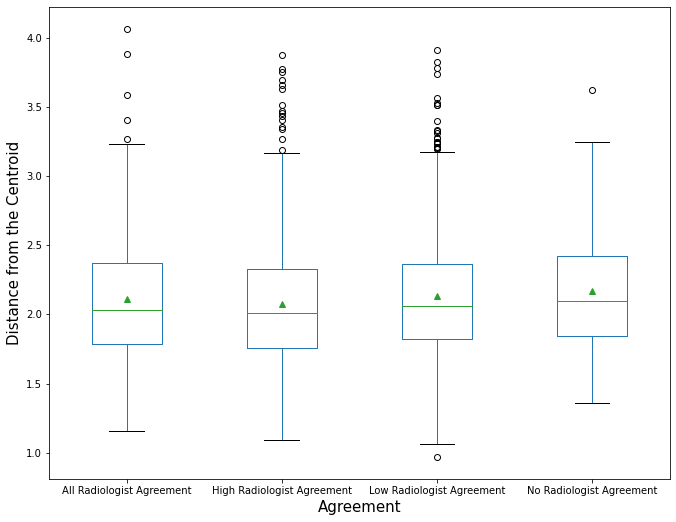

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df_distance.boxplot(by='Agreement',column =['Distance'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
#plt.ylim([0.0, 1.0])
plt.ylabel("Distance from the Centroid", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
#plt.xticks([0,1, 2, 3],['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree'])
plt.show()

In [ ]:
m1 = df_distance.groupby(['Agreement'])['Distance'].mean().values
print(m1)

[2.1104763 2.0773711 2.132785  2.1698909]


In [ ]:
m2 = df_distance.groupby(['Agreement'])['Distance'].median().values
print(m2)

[2.031861  2.0104065 2.060419  2.1004255]
